# NLP. Week 5. Fully connected language models

## Language model
Feed-forward language models for text generation are neural network-based models that generate sequences of text by processing input sequences of words (or characters) through one or more feed-forward layers. These models are often used in natural language processing tasks such as language modeling, text generation, and machine translation. Here's an explanation of feed-forward language models for text generation:

### Architecture
Feed-forward language models typically consist of the following components:

- **Embedding Layer**: The input sequences of words (or characters) are first converted into dense, low-dimensional vectors called embeddings using an embedding layer. Each word in the vocabulary is represented by a unique embedding vector, capturing semantic and syntactic similarities between words based on their context.

- **Feed-forward Layers**: After the input sequences are converted into embeddings, they are passed through one or more feed-forward layers. Each feed-forward layer consists of a sequence of linear transformations followed by activation functions (e.g., ReLU, tanh). These layers capture complex relationships between the input embeddings and produce higher-level representations of the input sequences.

![](https://github.com/tsmatz/nlp-tutorials/blob/master/images/language_model_beginning.png?raw=true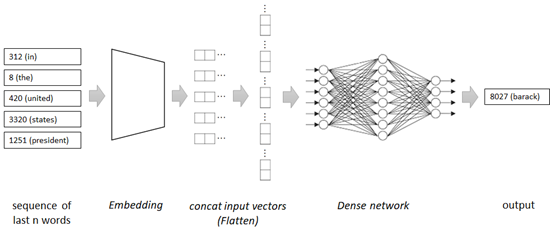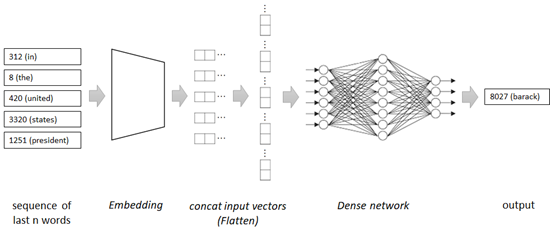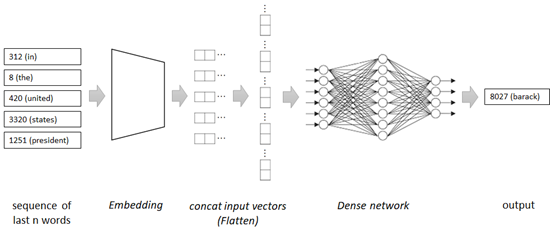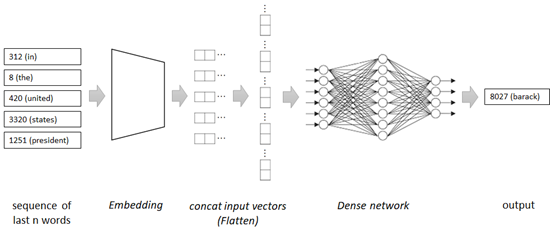)

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import string
text = """
Alice was beginning to get very tired of sitting by her sister on the bank, and of having nothing to do: 
once or twice she had peeped into the book her sister was reading, but it had no pictures or conversations 
in it, 'and what is the use of a book,' thought Alice 'without pictures or conversation?'
"""

class CharLanguageModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CharLanguageModel, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        embedded = self.embedding(input)
        output = self.fc(embedded)
        output = self.softmax(output)
        return output

# Prepare training data
all_characters = string.printable
n_characters = len(all_characters)

# Function to convert text to tensor
def text_to_tensor(text):
    tensor = torch.zeros(len(text)).long()
    for c in range(len(text)):
        tensor[c] = all_characters.index(text[c])
    return tensor

# Function to generate training examples
def generate_training_example(text, chunk_len):
    start_idx = torch.randint(0, len(text) - chunk_len, (1,))
    end_idx = start_idx + chunk_len + 1
    input_seq = text_to_tensor(text[start_idx:end_idx])
    target_seq = text_to_tensor(text[start_idx+1:end_idx+1])
    return input_seq, target_seq

# Instantiate the model
hidden_size = 100
model = CharLanguageModel(n_characters, hidden_size, n_characters)

# Loss function and optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
n_iters = 10000
print_every = 1000
chunk_len = 10
for i in range(1, n_iters + 1):
    input_seq, target_seq = generate_training_example(text, chunk_len)
    if len(input_seq)!= len(target_seq):
        continue
    optimizer.zero_grad()
    output = model(input_seq.unsqueeze(0))
    loss = criterion(output.squeeze(0), target_seq)
    loss.backward()
    optimizer.step()

    if i % print_every == 0:
        print(f'Iteration {i}, Loss: {loss.item()}')


Iteration 1000, Loss: 1.4660900831222534
Iteration 2000, Loss: 1.4820716381072998
Iteration 3000, Loss: 1.5302850008010864
Iteration 4000, Loss: 0.9148682951927185
Iteration 5000, Loss: 0.9483805298805237
Iteration 6000, Loss: 1.624928593635559
Iteration 7000, Loss: 1.2545435428619385
Iteration 8000, Loss: 1.5472545623779297
Iteration 9000, Loss: 1.2973827123641968
Iteration 10000, Loss: 1.3007453680038452


In [19]:
# Function to generate text using the trained model
def generate_text(start_string='Hello', predict_len=100, temperature=0.9):
    model.eval()
    input_seq = text_to_tensor(start_string)
    hidden = torch.zeros(1, hidden_size)
    output_str = start_string

    for i in range(predict_len):
        output = model(input_seq.unsqueeze(0))
        output_dist = output.squeeze(0)[-1].div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        predicted_char = all_characters[top_i]
        output_str += predicted_char
        input_seq = text_to_tensor(predicted_char)
    
    return output_str

# Generate text
generated_text = generate_text(start_string='Alice', predict_len=50)
print(generated_text)


Aliceg[vB|LRQ.LVW4[ -qTLc*B|AWZueV w(V@[!zhZ=t#8@ Ti<3


## Perplexity
Perplexity is a measure of how well a language model predicts a given sequence of words. Perplexity is defined as the exponentiated average negative log-likelihood of a sequence. If we have a tokenized
sequence $X = (x_0, x_1, \dots, x_t)$, then the perplexity of $X$ is,

$$\text{PPL}(X) = \exp \left\{ {-\frac{1}{t}\sum_i^t \log p_\theta (x_i|x_{<i}) } \right\}$$

where $\log p_\theta (x_i|x_{<i})$ is the log-likelihood of the ith token conditioned on the preceding tokens $x_{<i}$ according to our model. 

Intuitively, it can be thought of as an evaluation of the model's ability to predict uniformly among the set of specified tokens in a corpus. Importantly, this means that the tokenization procedure has a direct impact on a model's perplexity which should always be taken into consideration when comparing different models.

In [25]:
import nltk
from nltk.util import ngrams
from collections import Counter

# Sample text data
text = "This is a sample text used for demonstration purposes. This is a text with two sentences."

# Tokenize the text
tokens = nltk.word_tokenize(text)

# Generate n-grams
n = 3  # Choose the order of n-gram model
n_grams = list(ngrams(tokens, n))

# Count the occurrences of each n-gram
n_gram_counts = Counter(n_grams)

print("Sample n-grams and their counts:")
for n_gram, count in n_gram_counts.most_common(5):
    print(n_gram, "->", count)

# Calculate probabilities for each n-gram
total_n_grams = sum(n_gram_counts.values())
n_gram_probs = {n_gram: count / total_n_grams for n_gram, count in n_gram_counts.items()}

# Define a function to predict the next word given a sequence of words
def predict_next_word(sequence):
    next_word_probs = {}
    for n_gram, prob in n_gram_probs.items():
        if n_gram[:-1] == sequence:
            next_word_probs[n_gram[-1]] = prob
    return next_word_probs

# Example usage:
sequence = ('is', 'a')
next_word_probs = predict_next_word(sequence)
print("Next word probabilities:", next_word_probs)


Sample n-grams and their counts:
('This', 'is', 'a') -> 2
('is', 'a', 'sample') -> 1
('a', 'sample', 'text') -> 1
('sample', 'text', 'used') -> 1
('text', 'used', 'for') -> 1
Next word probabilities: {'sample': 0.0625, 'text': 0.0625}


In [23]:
test_text = "This is a test text."

# Tokenize the test text
test_tokens = nltk.word_tokenize(test_text)

# Generate n-grams for the test text
test_n_grams = list(ngrams(test_tokens, n))

# Calculate perplexity
perplexity = 1
for n_gram in test_n_grams:
    if n_gram in n_gram_probs:
        perplexity *= 1 / n_gram_probs[n_gram]
perplexity = perplexity ** (1 / len(test_n_grams))

print("Perplexity of the language model:", perplexity)


Perplexity of the language model: 1.681792830507429


## Beam search

The beam search algorithm selects multiple tokens for a position in a given sequence based on conditional probability. The algorithm can take any number of N best alternatives through a hyperparameter know as Beam width. In greedy search we simply took the best word for each position in the sequence, where here we broaden our search or "width" to include other words that might fit better.

Greedy search looks at each position in the output sequence in isolation. A word is decided based on highest probability and we continue moving down the rest of the sentence, not going back to earlier ones. With Beam search, we also take the N best output sequences and look at the current preceding words and the probabilities compared to the current position we are decoding in the sequence.


In [24]:
def beam_search(seed_sequence, beam_width, max_length):
    sequences = [[list(seed_sequence), 1.0]]
    for _ in range(max_length):
        next_sequences = []
        for seq, score in sequences:
            next_word_probs = predict_next_word(tuple(seq[-(n-1):]))
            for next_word, next_word_prob in next_word_probs.items():
                new_seq = seq + [next_word]
                new_score = score * next_word_prob
                next_sequences.append([new_seq, new_score])
        next_sequences.sort(key=lambda x: x[1], reverse=True)
        sequences = next_sequences[:beam_width]
    return sequences

# Example usage:
seed_sequence = ['This', 'is']
generated_sequences = beam_search(seed_sequence, beam_width=3, max_length=5)
print("Generated sequences:")
for seq, score in generated_sequences:
    print(" ".join(seq), "-> Score:", score)


Generated sequences:
This is a sample text used for -> Score: 3.0517578125e-05


## Competition

[Competition](https://www.kaggle.com/t/b2a5dce8f98c413da4a03db11577fe6c)

> Your task is to create fully connected N-gram based language model for text generation. 

In [1]:
# !pip install torchtext

### Load data

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn import functional as F
from tqdm.notebook import tqdm

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

MAX_TOKENS = 50000


In [3]:
train_data = pd.read_csv('/kaggle/input/nlp-week-5-fcn-language-models/train.csv')['text']
train_data = train_data.fillna('')
train_data.head()

0    they hope the president elect stands up to his...
1    it's the latest in a string of test launches o...
2    the need to control an undesirable situation b...
3                                                     
4    personal intelligence is new kid on the block ...
Name: text, dtype: object

### Preprocessing
As the dataset is already preprocessed, we simply add `<start>` & `<end>` tokens to data

In [4]:
train_data = [" ".join(["<start>", x, "<end>"]) for x in train_data]
train_data[0]

'<start> they hope the president elect stands up to his party <end>'

In [5]:
def tokenize_text(train_data, tokenizer):
    for text in train_data:
        tokens = tokenizer(text)
        yield tokens

In [6]:
tokenizer = get_tokenizer('basic_english')
vocab = vocab = build_vocab_from_iterator(
    tokenize_text(train_data, tokenizer),
    specials=["<unk>"],
    max_tokens=MAX_TOKENS,
)
vocab.set_default_index(vocab["<unk>"])

In [7]:
idx2symbol = vocab.get_itos()
symbol2idx = vocab.get_stoi()

### Transform data

Tasnsform data for the our model

In [8]:
NGRAM = 5
SEQUENCE_LENGTH = NGRAM + 1 # n-gram + next word

input_sequences = []
for sequence in train_data:
    token_list = vocab(tokenizer(sequence))
    for i in range(SEQUENCE_LENGTH, len(token_list) + 1):
        sequences = token_list[i-SEQUENCE_LENGTH:i]
        input_sequences.append(sequences)
print("The number of training input sequence :{}".format(len(input_sequences)))
input_sequences = np.array(input_sequences)

The number of training input sequence :3376911


In [9]:
X, y = input_sequences[:,:-1], input_sequences[:,-1]

### Model
Define simple model for training

In [10]:
embedding_dim = 64

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class FCNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim=256):
        super().__init__()

        self.embedding = nn.Embedding(
            vocab_size,
            embedding_dim,
        )
        self.hidden = nn.Linear(embedding_dim*(SEQUENCE_LENGTH - 1), hidden_dim)
        self.classify = nn.Linear(hidden_dim, vocab_size)
        self.relu = nn.ReLU()

    def forward(self, inputs):
        outs = self.embedding(inputs)
        outs = torch.flatten(outs, start_dim=1)
        outs = self.hidden(outs)
        outs = self.relu(outs)
        logits = self.classify(outs)
        return logits
    
model = FCNModel(vocab.__len__(), embedding_dim).to(device)

### Train

In [11]:
num_epochs = 1

dataloader = DataLoader(
    list(zip(y, X)),
    batch_size=512,
    shuffle=True,
)

In [12]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
for epoch in range(num_epochs):
    for labels, seqs in tqdm(dataloader):
        # optimize
        optimizer.zero_grad()
        
        logits = model(seqs.to(device))
        
        loss = F.cross_entropy(logits, labels.to(device))
        loss.backward()
        optimizer.step()
        
        # calculate accuracy
        pred_labels = logits.argmax(dim=1)
        num_correct = (pred_labels == labels.to(device)).float().sum()
        accuracy = num_correct / len(labels)
        print("Epoch {} - loss: {:2.4f} - accuracy: {:2.4f}".format(epoch+1, loss.item(), accuracy), end="\r")
    print("")

  0%|          | 0/6596 [00:00<?, ?it/s]

Epoch 1 - loss: 5.8558 - accuracy: 0.16975


### Predict

In [13]:
start_index = symbol2idx["<start>"]
end_index = symbol2idx["<end>"]
MAX_SENTENCE_LENGTH = 128

def predict(sentence, progressive_output=True):
    test_sequence = vocab(tokenizer(sentence))
    
    if len(test_sequence) < NGRAM:
        return [start_index, *test_sequence, end_index]
    
    test_sequence.insert(0, start_index)
    
    for _ in range(MAX_SENTENCE_LENGTH):
        input_tensor = torch.tensor([test_sequence[-NGRAM:]], dtype=torch.int64).to(device)
        pred_logits = model(input_tensor)
        pred_index = pred_logits.argmax()
        test_sequence.append(pred_index.item())
        
        if pred_index.item() == end_index:
            break
    return test_sequence

def decode_generated_sequence(generated_sequence):
    return ' '.join(idx2symbol[symb] for symb in generated_sequence[1:-1])

In [14]:
generated_sequence = predict("health experts said it is", progressive_output=False)
decode_generated_sequence(generated_sequence)

'health experts said it is a good thing to be a lot of the'

### Submission

In [15]:
test_df = pd.read_csv('/kaggle/input/nlp-week-5-fcn-language-models/test.csv')
test_df.head()

,id,sample
0,0,what if in doing so we won't just
1,1,it should have been a glorious week for
2,2,a few protesters who refused to leave remained
3,4,scientists didn't know if humans played that game
4,5,here are five ways to get some beauty


In [16]:
test_df['prediction'] = test_df['sample'].apply(lambda x :decode_generated_sequence(predict(str(x), progressive_output=False)))

In [17]:
test_df.head()

,id,sample,prediction
0,0,what if in doing so we won't just,what if in doing so we won ' t just a lot of the
1,1,it should have been a glorious week for,it should have been a glorious week for the fi...
2,2,a few protesters who refused to leave remained,a few protesters who refused to leave remained
3,4,scientists didn't know if humans played that game,scientists didn ' t know if humans played that...
4,5,here are five ways to get some beauty,here are five ways to get some beauty of the w...


In [18]:
test_df[['id','prediction']].to_csv('submission.csv', index=False)